# Year 2023 Day 14

[--- Day 14: Parabolic Reflector Dish ---](https://adventofcode.com/2023/day/14)


In [1]:
import pandas as pd

import xarray as xr

In [2]:
from advent_of_code.y_2023.problem_202314 import AdventOfCodeProblem202314


problem = AdventOfCodeProblem202314()

In [3]:
history_xda = problem.log_part_2(
    problem.parse_input_text_file(), max_full_rotations_count=200, verbose=False
)["board_history"]
history_xda = history_xda.assign_coords(dict(time=range(0, history_xda["time"].size)))
history_xda.sizes

Saved zarr to generated/advent_of_code/year_2023/day_14/history.zarr


Frozen({'time': 801, 'row': 100, 'col': 100})

In [4]:
history_xda_012 = xr.where(
    history_xda == ord("#"), 2, xr.where(history_xda == ord("O"), 1, 0)
)

The initial state. Rocks (orange pixels) are dispersed through the board (mentioned as parabolic reflector dish in the problem description)


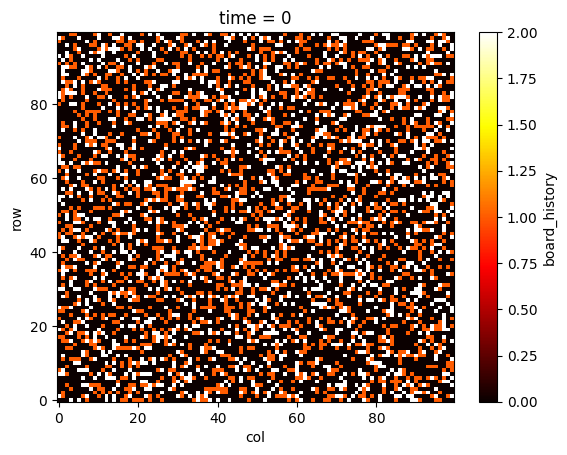

In [5]:
history_xda_012.sel(time=0).plot(cmap="hot")

Let's plot the next states of the simulation. The tilt cycle is the following: North, West, South, East. This is emphasized by the facetting (4 columns for the 4 directions).


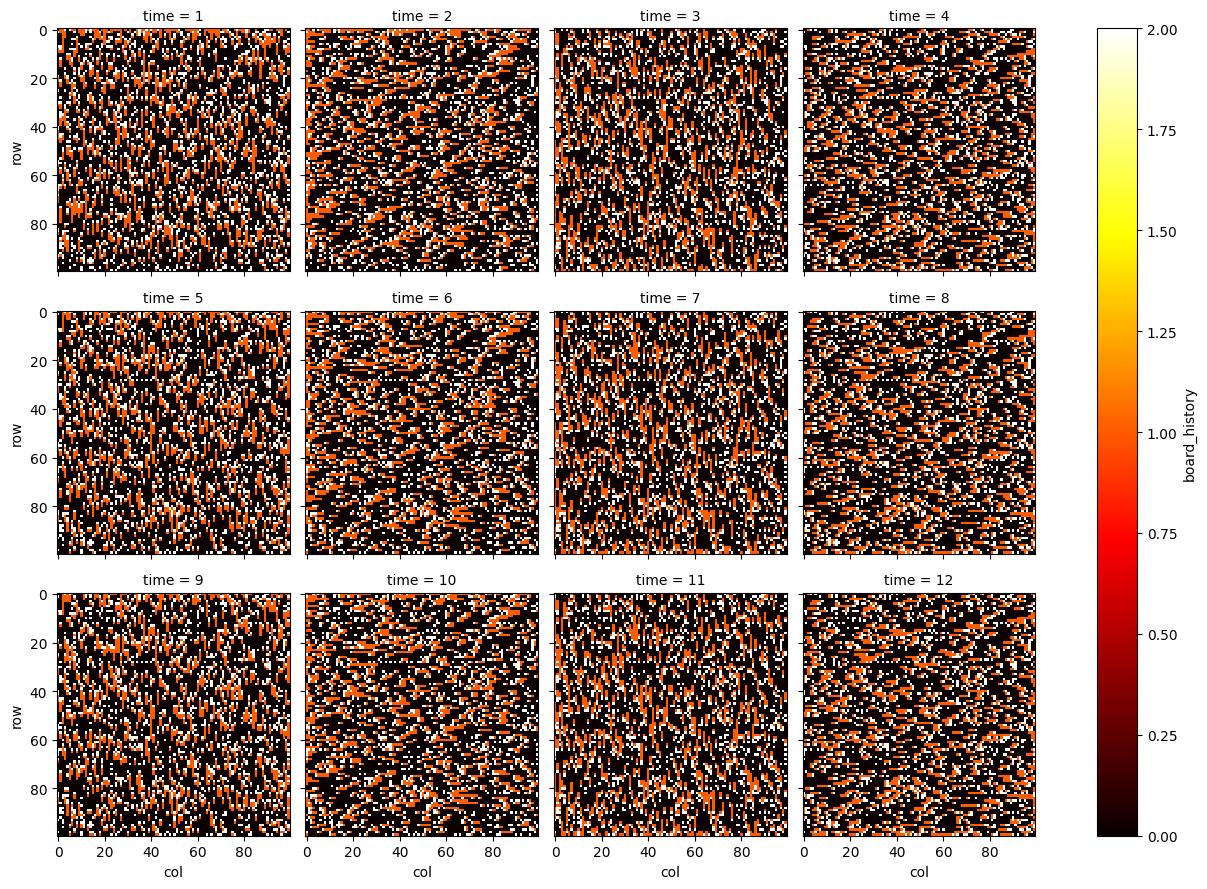

In [6]:
history_xda_012.sel(time=range(1, 1 + 3 * 4)).plot(
    col="time", x="col", y="row", yincrease=False, col_wrap=4, cmap="hot"
)

We can see that the rocks are now significantly more aligned at each state. Indeed each state is the "equilibrium" state due to gravity favoring the tilting direction.

The goal of the problem's part 2 is to detect the first cycle leading to a repetition in the rocks configuration, and then determining the period, being the number of cycles needed to achieve the same rocks configuration. Indeed, the requested number of simulation steps is extremely high to be ran in a reasonable time (1000000000). So, finding such a period will allow to not compute the actual number of cycles wanted in the problem description, but only a significantly smaller subset of it.

This is not a bruteforce problem, but one of the "simulation with cycle" problems. Several problems exhibit this philosophy of finding a period of repeating states in a simulation.


In [7]:
result = problem.solve_part_2_details(problem.parse_input_text_file())

i=141 found duplicates for indices=(107, 141)
i=141 found duplicates for indices=(107, 141) and period=34


$t_0$ is the first time (in other words, simulation step) at which a period of repeating states starts.

$T$ is this period.


In [8]:
t0 = result["start"]
T = result["period"]

print("Cycle start:", t0, ";", "Cycle period:", T)

Cycle start: 107 ; Cycle period: 34


The following plot shows that the same rock configuration is achieved at least two times, for all directions.


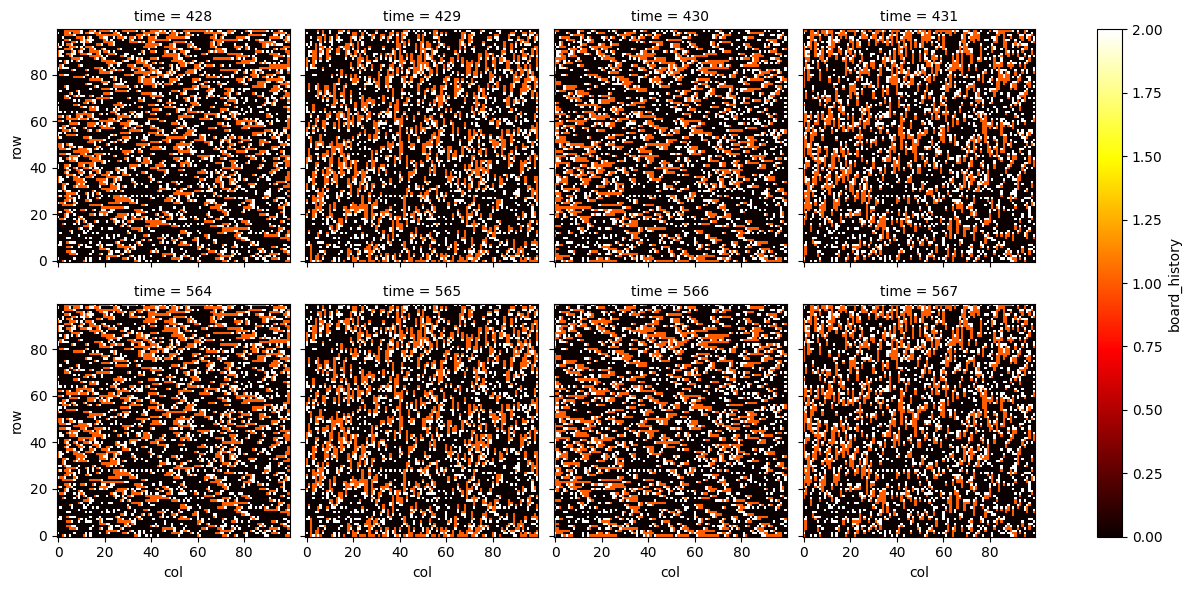

In [9]:
history_xda_012.sel(
    time=[(t0 + n * T) * 4 + offset for n in range(2) for offset in range(4)]
).plot(col="time", col_wrap=4, cmap="hot")

Formal verification that the states plot above are identical:


In [10]:
print(
    [
        (
            history_xda_012.sel(time=t0 * 4 + offset)
            == history_xda_012.sel(time=(t0 + T) * 4 + offset)
        )
        .all()
        .item()
        for offset in range(4)
    ]
)

[True, True, True, True]


We can visualize the transition from _transitory state_ (régime transitoire) to _permanent state_ (régime permanent) by hashing the various board states. Hashing is a projection from some space to a finite space (a range of integer values). This projection is then easy to visualize for a human, as the complexity (a 2D array) is reduced to a single dimension. Hashing can be seen as assigning a mark to a student's assignment, but without an ordering.

Using the hash of the successive states produces a sort of time-dependant signal, well-suited to visualize the periodic property of this problem's simulation.


In [11]:
hashed = {
    time: hash(str(history_xda_012.sel(time=time).values.reshape(-1).tolist()))
    for time in range(history_xda["time"].size)
}
df = pd.DataFrame.from_dict(hashed, orient="index", columns=["hash"])
df = df.reset_index(names=["time"])
df

,time,hash
0,0,-6255706038563561396
1,1,7666046535457640526
2,2,-204875016706486137
3,3,2682252692307600113
4,4,3860986407156650870
...,...,...
796,796,890409486566559608
797,797,215453053807933735
798,798,6572444434521128395
799,799,-6102365140605933199


In [12]:
from advent_of_code.visualization.observable_plot import (
    ObservablePlotBuilder,
    create_obsplot_instance,
)
from pyobsplot import Plot

initial_kwargs = {
    "marginLeft": 45,
    "x": dict(axis="both"),
    "y": dict(
        tickFormat=".0e",
        nice=True,
        ticks=10,
    ),
    "width": 1200,
    # "style": {"backgroundColor": "#222"},
}
plotter = ObservablePlotBuilder(
    initial_kwargs=initial_kwargs,
    _op=create_obsplot_instance(theme="dark"),
)

plotter_ = (
    plotter.copy()
    .stack(lambda: [Plot.frame()])
    # .stack(lambda: [Plot.ruleX([0], {"stroke": "white"})])
    .stack(lambda: [Plot.ruleY([0], {"stroke": "white"})])
    .stack(
        lambda: [
            Plot.ruleX(
                list(range(0, df["time"].size, 4)),
                {"strokeOpacity": 0.2},
            )
        ]
    )
    .stack(
        lambda: [
            Plot.line(df[: (t0 * 4)], {"x": "time", "y": "hash", "stroke": "orange"})
        ]
    )
    .stack(
        lambda: [
            Plot.line(
                df[t0 * 4 :],
                {"x": "time", "y": "hash", "stroke": "#0f0"},
            )
        ]
    )
    .stack(lambda: [Plot.ruleX([t0 * 4], {"stroke": "red", "strokeWidth": 4})])
    .stack(
        lambda: [
            Plot.ruleX([(t0 + i * T) * 4], {"stroke": "red", "strokeWidth": 4})
            for i in range(3)
        ]
    )
)
plotter_.plot(verbose=True)

KeyError: 0

So, there is no need to compute 1000000000 cycles, as stated in the problem's description. The "load signal" is periodic and starting early in the simulation, so once the period has been identified, there is enough information to know the state at any time superior to the $t_0$ at which the periodicity starts.

The formula is:

$$
s = (t - t_0) \% T
$$

where %s% is the offset, starting from $t_0$, giving the step to get the load value from.

By assigning the number of wanted cycles (1000000000) to $t$, we can determine the total load by looking values in the period.

In the plot below, step of interest is highlighted by a magenta vertical line.

In [13]:
t = 1000000000

plotter_.copy().stack(
    (
        lambda: [
            Plot.ruleX(
                [((t0 + ((t - t0) % T)) * 4)], {"stroke": "magenta", "strokeWidth": 4}
            )
        ]
    )
).plot()

KeyError: 0